In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [6]:
# Load CSV
df = pd.read_csv("/content/drive/MyDrive/Dataset/online_retail_II.csv", encoding='ISO-8859-1')

# Drop rows with missing Customer ID
df = df.dropna(subset=['Customer ID'])

# Remove negative or cancelled transactions
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Total Price per line item
df['TotalPrice'] = df['Quantity'] * df['Price']

# Convert date column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [7]:
# Use latest date to calculate recency
latest_date = df['InvoiceDate'].max()

# Group by Customer ID
customer_df = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': ['sum', 'mean']
})

customer_df.columns = ['recency', 'frequency', 'ltv', 'aov']
customer_df = customer_df.reset_index()


In [8]:
X = customer_df[['recency', 'frequency', 'aov']]
y = customer_df['ltv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
model = XGBRegressor()
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [10]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 1519.18
RMSE: 10541.78


In [11]:
customer_df['predicted_ltv'] = model.predict(customer_df[['recency', 'frequency', 'aov']])
customer_df['segment'] = pd.qcut(customer_df['predicted_ltv'], q=4, labels=['Low', 'Mid', 'High', 'Very High'])


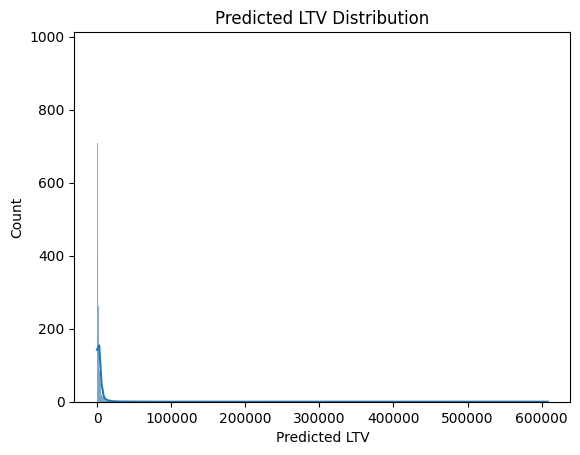

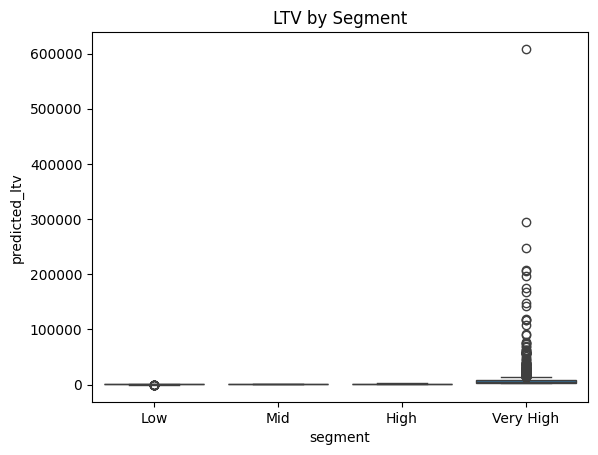

In [12]:
# LTV Distribution
sns.histplot(customer_df['predicted_ltv'], kde=True)
plt.title("Predicted LTV Distribution")
plt.xlabel("Predicted LTV")
plt.show()

# Boxplot by segment
sns.boxplot(x='segment', y='predicted_ltv', data=customer_df)
plt.title("LTV by Segment")
plt.show()


In [13]:
customer_df.to_csv("final_ltv_predictions.csv", index=False)
